# Colorization using optimization

This is a python implementation of the paper: [Colorization using Optimazation](http://www.cs.huji.ac.il/~yweiss/Colorization/) (Anat Levin, Dani Lischinski and Yair Weiss). With the idea that neighboring pixels in a photo should have similar color if their intensity levels are close, it is possible to colorize a black-and-white photo with a little hints.

$$
J \big( U \big) = \sum_r \Big( U\big(r\big) - \sum_{s\in N(r)} w_{rs} U(s) \Big)^2
$$

r: a pixel (x,y)  
s: neighboring pixels of point r.  
$ w_{rs} $ : weight between points r and s.  
$ U \big( r \big) $ : chrominance channel "U" in YUV color space of pixel r

if 2 neighboring pixels have similar intensity (channel Y), then we assume they are more likely to have similar color (channel U &amp; V). Otherwise, they should have less similar color. To represent this weight, we use this affinity function (equation 2 in the paper).

$$
w_{rs} \propto \exp \Big( \frac{-\big( Y(r) - Y(s) \big)^2 }{2 \sigma_r^2} \Big)
$$

$ Y \big( r \big) $ : intensity value (channel Y) in YUV color space of pixel r.

The above concept turns out to be a optimization problem of the form: 

$ A \ \ \vec{x} = \vec{b} $

if the image is of size 10 &times; 10 pixels, the total number of pixels is 100. Then matrix A will be of size 100 rows &times; 100 columns = 10000 pixels. As the following illustration:

$$
\begin{bmatrix}
w_{(1,1),(1,1)} & w_{(1,1),(1,2)} & w_{(1,1),(1,3)} & \cdots &
w_{(1,1),(1,9)} & w_{(1,1),(1,10)} & w_{(1,1),(2,1)} & \cdots &
w_{(1,1),(10,9)} & w_{(1,1),(10,10)} \\
w_{(1,2),(1,1)} & w_{(1,2),(1,2)} & w_{(1,2),(1,3)} & \cdots & & & & \cdots & & w_{(1,2),(10,10)} \\
w_{(1,3),(1,1)} & w_{(1,3),(1,2)} & \cdots & & & & & \cdots & & w_{(1,3),(10,10)} \\
w_{(1,3),(1,1)} & \cdots & & & & & & \cdots & & w_{(1,3),(10,10)} \\
\vdots & \vdots & & & & & & \vdots & & \vdots \\
w_{(10,10),(1,1)} & w_{(10,10),(1,2)} & w_{(10,10),(1,3)} & \cdots & & & & \cdots & w_{(10,10),(10,9)} & w_{(10,10),(10,10)} \\
\end{bmatrix}_{100 \times 100}
$$

$ w_{(1,1),(10,9)} $ means the weight of pixel:(1,1) and pixel:(10,9) in the window with the center:(1,1), so $ w_{(1,1),(1,1)}, w_{(2,2),(2,2)}, w_{(n,n),(n,n)} $ will always have the weight value: 1.0. If the window width is 1, the equation $ A \vec{x} = \vec{b} $ should look like:

$$
\begin{bmatrix}
1               & w_{(1,1),(1,2)} & 0 & 0               & 0 & 0 & 0 & \cdots \\
w_{(1,2),(1,1)} & 1               & w_{(1,2),(1,3)} & 0 & 0 & 0 & 0 & \cdots \\
0               & w_{(1,3),(1,2)} & 1 & w_{(1,3),(1,4)} & 0 & 0 & 0 & \cdots \\
0               & 0 & w_{(1,4),(1,3)} & 1 & w_{(1,4),(1,5)} & 0 & 0 & \cdots \\
\vdots          & 0               & 0 & w_{(1,5),(1,4)}               & 1 & w_{(1,5),(1,6)} & 0 & \vdots
\end{bmatrix}_{100 \times 100}
\ \ \begin{bmatrix}
x_{(1,1)} \\ x_{(1,2)} \\ x_{(1,3)} \\ \cdots \\ x_{(10,9)} \\ x_{(10,10)}
\end{bmatrix}_{100 \times 1}
= \ \ \  \begin{bmatrix}
b_{(1,1)} \\ b_{(1,2)} \\ b_{(1,3)} \\ \cdots \\ b_{(10,9)} \\ b_{(10,10)}
\end{bmatrix}_{100 \times 1}
$$

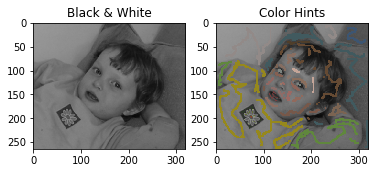

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import scipy
import logging
from scipy.misc import imread
np.set_printoptions(precision=8, suppress=True)

# set the photo file path
path_pic = '/Users/larrysu/repos/mconda3/cv01/ex_1.bmp'
path_pic_marked = '/Users/larrysu/repos/mconda3/cv01/ex_1_marked.bmp'
# window width
wd_width = 1

pic_o_rgb = imread(path_pic)
pic_o = pic_o_rgb.astype(float)/255
pic_m_rgb = imread(path_pic_marked)
pic_m = pic_m_rgb.astype(float)/255

fig = plt.figure()
fig.add_subplot(1,2,1).set_title('Black & White')
imgplot = plt.imshow(pic_o)
fig.add_subplot(1,2,2).set_title('Color Hints')
imgplot = plt.imshow(pic_m)
plt.show();

With some human intervention, an image with "color hints" can be used to generate colors for all pixels on the photo. Before start, we need to prepare some useful functions:

In [2]:
# the window class, find the neighbor pixels around the center.
class WindowNeighbor:
    def __init__(self, width, center, pic):
        # center is a list of [row, col, Y_intensity]
        self.center = [center[0], center[1], pic[center][0]]
        self.width = width
        self.neighbors = None
        self.find_neighbors(pic)
        self.mean = None
        self.var = None

    def find_neighbors(self, pic):
        self.neighbors = []
        ix_r_min = max(0, self.center[0] - self.width)
        ix_r_max = min(pic.shape[0], self.center[0] + self.width + 1)
        ix_c_min = max(0, self.center[1] - self.width)
        ix_c_max = min(pic.shape[1], self.center[1] + self.width + 1)
        for r in range(ix_r_min, ix_r_max):
            for c in range(ix_c_min, ix_c_max):
                if r == self.center[0] and c == self.center[1]:
                    continue
                self.neighbors.append([r,c,pic[r,c,0]])

    def __str__(self):
        return 'windows c=(%d, %d, %f) size: %d' % (self.center[0], self.center[1], self.center[2], len(self.neighbors))

# affinity functions, calculate weights of pixels in a window by their intensity.
def affinity_a(w):
    nbs = np.array(w.neighbors)
    sY = nbs[:,2]
    cY = w.center[2]
    diff = sY - cY
    sig = np.var(np.append(sY, cY))
    if sig < 1e-6:
        sig = 1e-6  
    wrs = np.exp(- np.power(diff,2) / (sig * 2.0))
    wrs = - wrs / np.sum(wrs)
    nbs[:,2] = wrs
    return nbs

# translate (row,col) to/from sequential number
def to_seq(r, c, rows):
    return c * rows + r

def fr_seq(seq, rows):
    r = seq % rows
    c = int((seq - r) / rows)
    return (r, c)

# combine 3 channels of YUV to a RGB photo: n x n x 3 array
def yuv_channels_to_rgb(cY,cU,cV):
    ansRGB = [colorsys.yiq_to_rgb(cY[i],cU[i],cV[i]) for i in range(len(ansY))]
    ansRGB = np.array(ansRGB)
    pic_ansRGB = np.zeros(pic_yuv.shape)
    pic_ansRGB[:,:,0] = ansRGB[:,0].reshape(pic_rows, pic_cols, order='F')
    pic_ansRGB[:,:,1] = ansRGB[:,1].reshape(pic_rows, pic_cols, order='F')
    pic_ansRGB[:,:,2] = ansRGB[:,2].reshape(pic_rows, pic_cols, order='F')
    return pic_ansRGB

def init_logger():
    FORMAT = '%(asctime)-15s %(message)s'
    logging.basicConfig(format=FORMAT, level=logging.DEBUG)
    logger = logging.getLogger()
    return logger

### Prepare the Matrix: A

The matrix A holds all the weights between each pixel. Because only pixels in a window have weight with each other, so this is a sparse matrix of size n &times; n (n is the total number of pixels)

In [3]:
log = init_logger()
(pic_rows, pic_cols, _) = pic_o.shape
pic_size = pic_rows * pic_cols

channel_Y,_,_ = colorsys.rgb_to_yiq(pic_o[:,:,0],pic_o[:,:,1],pic_o[:,:,2])
_,channel_U,channel_V = colorsys.rgb_to_yiq(pic_m[:,:,0],pic_m[:,:,1],pic_m[:,:,2])

map_colored = (abs(channel_U) + abs(channel_V)) > 0.0001

pic_yuv = np.dstack((channel_Y, channel_U, channel_V))
weightData = []
num_pixel_bw = 0

# build the weight matrix for each window.
for c in range(pic_cols):
    for r in range(pic_rows):
        res = []
        w = WindowNeighbor(wd_width, (r,c), pic_yuv)
        if not map_colored[r,c]:
            weights = affinity_a(w)
            for e in weights:
                weightData.append([w.center,(e[0],e[1]), e[2]])
        weightData.append([w.center, (w.center[0],w.center[1]), 1.])

sp_idx_rc_data = [[to_seq(e[0][0], e[0][1], pic_rows), to_seq(e[1][0], e[1][1], pic_rows), e[2]] for e in weightData]
sp_idx_rc = np.array(sp_idx_rc_data, dtype=np.integer)[:,0:2]
sp_data = np.array(sp_idx_rc_data, dtype=np.float64)[:,2]

matA = scipy.sparse.csr_matrix((sp_data, (sp_idx_rc[:,0], sp_idx_rc[:,1])), shape=(pic_size, pic_size))

### Vector b

using chrominance channels U,V to get the vector $ \vec{b} $, then we can solve the equation: 

$$
A \ \ \vec{x} = \vec{b}
$$

In [4]:
b_u = np.zeros(pic_size)
b_v = np.zeros(pic_size)
idx_colored = np.nonzero(map_colored.reshape(pic_size, order='F'))
pic_u_flat = pic_yuv[:,:,1].reshape(pic_size, order='F')
b_u[idx_colored] = pic_u_flat[idx_colored]

pic_v_flat = pic_yuv[:,:,2].reshape(pic_size, order='F')
b_v[idx_colored] = pic_v_flat[idx_colored]

### Solve the optimazation problem

$$
A \ \ \vec{x} = \vec{b}
\\
\vec{x} = \big( A^T \ A \big)^{-1} \ A^T \ \vec{v}
$$

2017-09-08 14:45:17,382 Optimizing Ax=b
2017-09-08 14:45:18,376 Optimized Ax=b


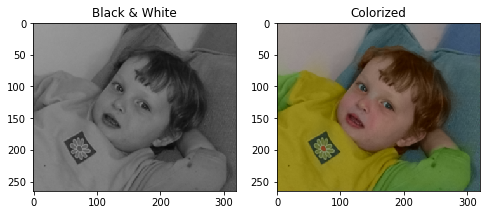

In [5]:
log.info('Optimizing Ax=b')
ansY = pic_yuv[:,:,0].reshape(pic_size, order='F')
ansU = scipy.sparse.linalg.spsolve(matA, b_u)
ansV = scipy.sparse.linalg.spsolve(matA, b_v)
pic_ans = yuv_channels_to_rgb(ansY,ansU,ansV)
log.info('Optimized Ax=b')

fig = plt.figure(figsize=(8, 6))
fig.add_subplot(1,2,1).set_title('Black & White')
imgplot = plt.imshow(pic_o_rgb)
fig.add_subplot(1,2,2).set_title('Colorized')
imgplot = plt.imshow(pic_ans)
plt.show();

### Iterative method of optimization : jacobi

We can also implement a simple iterative method to find an answer close to the solution. Here shows the result of 50, 100, 300 iterations, more iteration will generate better result.

$
A \ x = b \\
D \ x = b - R x \\
\to x^{k+1} = D^{-1} \big( b - R \ x \big)
$

D: diagonal matrix of A.  
R: A - D

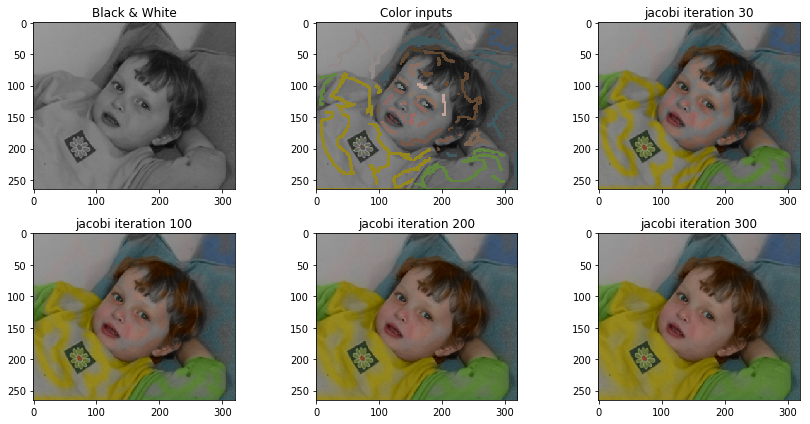

In [6]:
# jacobi method for iterative optimization
def jacobi(A, b, x, n, verbose=False):
    D = A.diagonal()
    R = A - scipy.sparse.diags(D)
    for i in range(n):
        x = (b - R.dot(x)) / D
    return x

ansY = pic_yuv[:,:,0].reshape(pic_size, order='F')
ansU1 = jacobi(matA, b_u, x=np.zeros(matA.shape[0]), n=30)
ansV1 = jacobi(matA, b_v, x=np.zeros(matA.shape[0]), n=30)
ansU2 = jacobi(matA, b_u, x=np.zeros(matA.shape[0]), n=100)
ansV2 = jacobi(matA, b_v, x=np.zeros(matA.shape[0]), n=100)
ansU3 = jacobi(matA, b_u, x=np.zeros(matA.shape[0]), n=200)
ansV3 = jacobi(matA, b_v, x=np.zeros(matA.shape[0]), n=200)
ansU4 = jacobi(matA, b_u, x=np.zeros(matA.shape[0]), n=300)
ansV4 = jacobi(matA, b_v, x=np.zeros(matA.shape[0]), n=300)

pic_ans1 = yuv_channels_to_rgb(ansY,ansU1,ansV1)
pic_ans2 = yuv_channels_to_rgb(ansY,ansU2,ansV2)
pic_ans3 = yuv_channels_to_rgb(ansY,ansU3,ansV3)
pic_ans4 = yuv_channels_to_rgb(ansY,ansU4,ansV4)

fig = plt.figure(figsize=(12, 6))
fig.add_subplot(2,3,1).set_title('Black & White')
imgplot = plt.imshow(pic_o_rgb)
fig.add_subplot(2,3,2).set_title('Color inputs')
imgplot = plt.imshow(pic_m_rgb)
fig.add_subplot(2,3,3).set_title('jacobi iteration 30')
imgplot = plt.imshow(pic_ans1)
fig.add_subplot(2,3,4).set_title('jacobi iteration 100')
imgplot = plt.imshow(pic_ans2)
fig.add_subplot(2,3,5).set_title('jacobi iteration 200')
imgplot = plt.imshow(pic_ans3)
fig.add_subplot(2,3,6).set_title('jacobi iteration 300')
imgplot = plt.imshow(pic_ans4)
plt.tight_layout()
plt.show();

### Try other photos

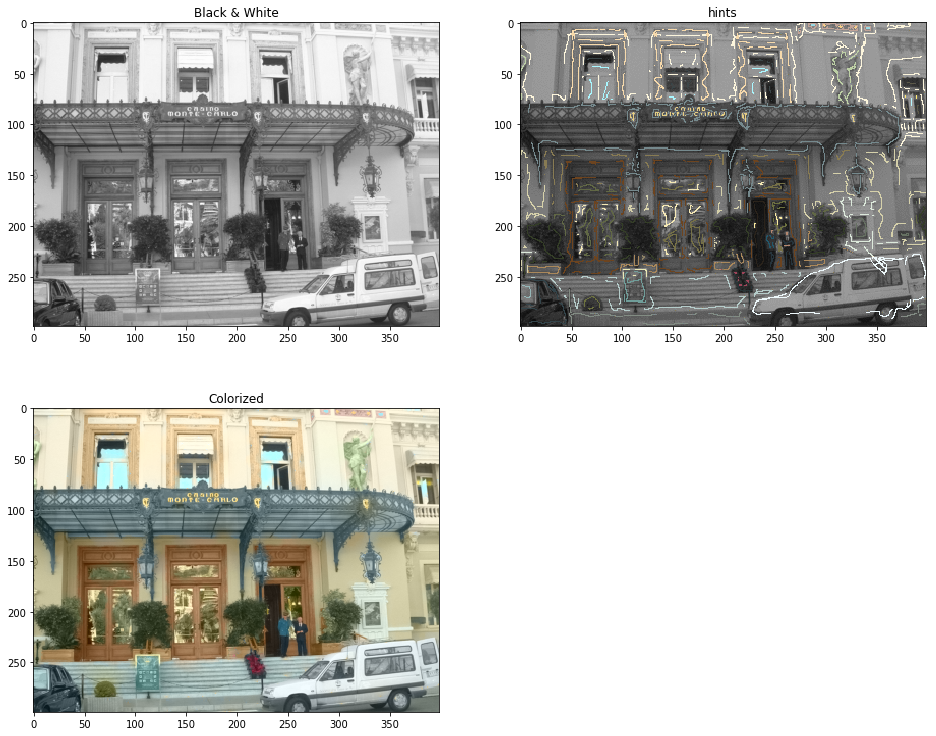

In [7]:
path_pic = '/Users/larrysu/repos/mconda3/cv01/ex_2.bmp'
path_pic_marked = '/Users/larrysu/repos/mconda3/cv01/ex_2_marked.bmp'
# window width
wd_width = 1

pic_o_rgb = imread(path_pic, mode='RGB')
pic_o = pic_o_rgb.astype(float)/255

pic_m_rgb = imread(path_pic_marked)
pic_m = pic_m_rgb.astype(float)/255

# prepare matrix A
(pic_rows, pic_cols, _) = pic_o.shape
pic_size = pic_rows * pic_cols

channel_Y,_,_ = colorsys.rgb_to_yiq(pic_o[:,:,0],pic_o[:,:,1],pic_o[:,:,2])
_,channel_U,channel_V = colorsys.rgb_to_yiq(pic_m[:,:,0],pic_m[:,:,1],pic_m[:,:,2])

map_colored = (abs(channel_U) + abs(channel_V)) > 0.0001

pic_yuv = np.dstack((channel_Y, channel_U, channel_V))
weightData = []
num_pixel_bw = 0

# build the weight matrix for each window.
for c in range(pic_cols):
    for r in range(pic_rows):
        res = []
        w = WindowNeighbor(wd_width, (r,c), pic_yuv)
        if not map_colored[r,c]:
            weights = affinity_a(w)
            for e in weights:
                weightData.append([w.center,(e[0],e[1]), e[2]])
        weightData.append([w.center, (w.center[0],w.center[1]), 1.])

sp_idx_rc_data = [[to_seq(e[0][0], e[0][1], pic_rows), to_seq(e[1][0], e[1][1], pic_rows), e[2]] for e in weightData]
sp_idx_rc = np.array(sp_idx_rc_data, dtype=np.integer)[:,0:2]
sp_data = np.array(sp_idx_rc_data, dtype=np.float64)[:,2]

matA = scipy.sparse.csr_matrix((sp_data, (sp_idx_rc[:,0], sp_idx_rc[:,1])), shape=(pic_size, pic_size))

# prepare vector b
b_u = np.zeros(pic_size)
b_v = np.zeros(pic_size)
idx_colored = np.nonzero(map_colored.reshape(pic_size, order='F'))
pic_u_flat = pic_yuv[:,:,1].reshape(pic_size, order='F')
b_u[idx_colored] = pic_u_flat[idx_colored]

pic_v_flat = pic_yuv[:,:,2].reshape(pic_size, order='F')
b_v[idx_colored] = pic_v_flat[idx_colored]

# optimize the problem
ansY = pic_yuv[:,:,0].reshape(pic_size, order='F')
ansU = scipy.sparse.linalg.spsolve(matA, b_u)
ansV = scipy.sparse.linalg.spsolve(matA, b_v)
pic_ans = yuv_channels_to_rgb(ansY,ansU,ansV)

fig = plt.figure(figsize=(16, 13))
fig.add_subplot(2,2,1).set_title('Black & White')
imgplot = plt.imshow(pic_o_rgb)
fig.add_subplot(2,2,2).set_title('hints')
imgplot = plt.imshow(pic_m_rgb)
fig.add_subplot(2,2,3).set_title('Colorized')
imgplot = plt.imshow(pic_ans)
plt.show();